## Техническое задание   
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).  

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных
Данные состоят из файлов, полученных из разных источников:

+ **contract.csv** — информация о договоре;  
+ **personal.csv** — персональные данные клиента;  
+ **internet.csv** — информация об интернет-услугах;  
+ **phone.csv** — информация об услугах телефонии.  

### Описание полей данных:
+ BeginDate – дата начала пользования услугами.  
+ EndDate – дата окончания пользования услугами.  
+ Type – тип оплаты: ежемесячный, годовой и тд.  
+ PaperlessBilling – безналичный расчет.  
+ PaymentMethod – способ оплаты.  
+ MonthlyCharges – ежемесячные траты на услуги.  
+ TotalCharges – всего потрачено денег на услуги.  
+ Dependents – наличие иждивенцев.  
+ Senior Citizen – наличие пенсионного статуса по возрасту.  
+ Partner – наличие супруга(и).  
+ MultipleLines – наличие возможности ведения параллельных линий во время звонка.

Во всех файлах столбец customerID содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.

# План работы
0. Изучение основных современных подходов по прогнозированию оттока клиентов.
1. Техническое задание. 
2. Изучение полученных данных.
3. Предобработка данных.
4. Исследовательский анализ данных.
5. Подготовка данных к расчету модели.
(Кодирование категориальных переменных, определение конечного датасета)
6. Моделирование
(Разбиение данных, определение исследуемых моделей, тестовая модель, подбор гиперпараметров, подбор важных фичей)
7. Тест моделей.
(Сравнение моделей, оценка эффективности моделей, определение порога нужных метрик)
8. Общий вывод.
9. Отчет.




## Изучение полученных данных

In [1]:
#Загрузка необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, plot_confusion_matrix

from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool
import catboost as cat

import lightgbm as lgb

 
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# для локальной работы
contract = pd.read_csv('D:/Yandex_Project_1/final_provider/contract.csv')
personal = pd.read_csv('D:/Yandex_Project_1/final_provider/personal.csv')
internet = pd.read_csv('D:/Yandex_Project_1/final_provider/internet.csv')
phone = pd.read_csv('D:/Yandex_Project_1/final_provider/phone.csv')

Используем функцию для просмотра уникальных значений внутри столбцов.

In [3]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].sort_values().unique())

In [4]:
contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
show_rows(contract)

Уникальные значения столбца customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Уникальные значения столбца BeginDate
['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '2016-08-01'
 '2016-09-01' '2016-10-01' '2016-11-01' '2016-12-01' '2017-01-01'
 '2017-02-01' '2017-03-01' '2017-04-01' '2017-05-01' '2017-06-01'
 '2017-07-01' '2017-08-01' '2017-09-01' '2017-10-01' '2017-11-01'
 '2017-12-01' '2018-01-01' '2018-02-01' '2018-03-01' '2018-04-01'
 '2018-05-01' '2018-06-01' '2018-07-01' '2018-08-01' '2018-09-01'
 '2018-10-01' '2018-11-01' '2018-12-01' '2019-

Примечателен факт, что пользователи перестали продлевать свои контракты только начиная с 2019-10-01, хотя компания предоставляет свои услуги, начиная с 2013-10-01

In [7]:
personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [8]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
show_rows(personal)

Уникальные значения столбца customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Уникальные значения столбца gender
['Female' 'Male']
Уникальные значения столбца SeniorCitizen
[0 1]
Уникальные значения столбца Partner
['No' 'Yes']
Уникальные значения столбца Dependents
['No' 'Yes']


In [10]:
internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [11]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [12]:
show_rows(internet)

Уникальные значения столбца customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Уникальные значения столбца InternetService
['DSL' 'Fiber optic']
Уникальные значения столбца OnlineSecurity
['No' 'Yes']
Уникальные значения столбца OnlineBackup
['No' 'Yes']
Уникальные значения столбца DeviceProtection
['No' 'Yes']
Уникальные значения столбца TechSupport
['No' 'Yes']
Уникальные значения столбца StreamingTV
['No' 'Yes']
Уникальные значения столбца StreamingMovies
['No' 'Yes']


In [13]:
phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [14]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [15]:
show_rows(phone)

Уникальные значения столбца customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-RRAMN' '9992-UJOEL'
 '9993-LHIEB']
Уникальные значения столбца MultipleLines
['No' 'Yes']


Так как данных немного, работу с полученными данными перенесем для удобства в один датасет, это не должно вызвать проблем с быстродействием и затраченной памятью.

In [16]:
df_full = contract.set_index('customerID').join(phone.set_index('customerID'))
df_full

BeginDate              EndDate            Type PaperlessBilling  \
customerID                                                                     
7590-VHVEG  2020-01-01                   No  Month-to-month              Yes   
5575-GNVDE  2017-04-01                   No        One year               No   
3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month              Yes   
7795-CFOCW  2016-05-01                   No        One year               No   
9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month              Yes   
...                ...                  ...             ...              ...   
6840-RESVB  2018-02-01                   No        One year              Yes   
2234-XADUH  2014-02-01                   No        One year              Yes   
4801-JZAZL  2019-03-01                   No  Month-to-month              Yes   
8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month              Yes   
3186-AJIEK  2014-08-01                   No        Two year              Yes   

                        PaymentMethod  MonthlyCharges TotalCharges  \
customerID                                                           
7590-VHVEG           Electronic check           29.85        29.85   
5575-GNVDE               Mailed check           56.95       1889.5   
3668-QPYBK               Mailed check           53.85       108.15   
7795-CFOCW  Bank transfer (automatic)           42.30      1840.75   
9237-HQITU           Electronic check           70.70       151.65   
...                               ...             ...          ...   
6840-RESVB               Mailed check           84.80       1990.5   
2234-XADUH    Credit card (automatic)          103.20       7362.9   
4801-JZAZL           Electronic check           29.60       346.45   
8361-LTMKD               Mailed check           74.40        306.6   
3186-AJIEK  Bank transfer (automatic)          105.65       6844.5   

           MultipleLines  
customerID                
7590-VHVEG           NaN  
5575-GNVDE            No  
3668-QPYBK            No  
7795-CFOCW           NaN  
9237-HQITU            No  
...                  ...  
6840-RESVB           Yes  
2234-XADUH           Yes  
4801-JZAZL           NaN  
8361-LTMKD           Yes  
3186-AJIEK            No  

[7043 rows x 8 columns]

In [17]:
df_full = df_full.join(personal.set_index('customerID'))
df_full = df_full.join(internet.set_index('customerID'))

In [18]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   MultipleLines     6361 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null 

Имеются данные с пропусками, это вызвано тем, что если услуга не оказывалась - ее просто не указывают для данного абонента, и после объединения мы видим пустые значения. Заполним такие значения.

In [19]:
df_full['MultipleLines'].fillna('No',inplace = True)
df_full['InternetService'].fillna('No',inplace = True)
df_full['OnlineSecurity'].fillna('No',inplace = True)
df_full['OnlineBackup'].fillna('No',inplace = True)
df_full['DeviceProtection'].fillna('No',inplace = True)
df_full['TechSupport'].fillna('No',inplace = True)
df_full['StreamingTV'].fillna('No',inplace = True)
df_full['StreamingMovies'].fillna('No',inplace = True)

In [20]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null 

In [21]:
df_full.head()

BeginDate              EndDate            Type PaperlessBilling  \
customerID                                                                     
7590-VHVEG  2020-01-01                   No  Month-to-month              Yes   
5575-GNVDE  2017-04-01                   No        One year               No   
3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month              Yes   
7795-CFOCW  2016-05-01                   No        One year               No   
9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges TotalCharges  \
customerID                                                           
7590-VHVEG           Electronic check           29.85        29.85   
5575-GNVDE               Mailed check           56.95       1889.5   
3668-QPYBK               Mailed check           53.85       108.15   
7795-CFOCW  Bank transfer (automatic)           42.30      1840.75   
9237-HQITU           Electronic check           70.70       151.65   

           MultipleLines  gender  SeniorCitizen Partner Dependents  \
customerID                                                           
7590-VHVEG            No  Female              0     Yes         No   
5575-GNVDE            No    Male              0      No         No   
3668-QPYBK            No    Male              0      No         No   
7795-CFOCW            No    Male              0      No         No   
9237-HQITU            No  Female              0      No         No   

           InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                
7590-VHVEG             DSL             No          Yes               No   
5575-GNVDE             DSL            Yes           No              Yes   
3668-QPYBK             DSL            Yes          Yes               No   
7795-CFOCW             DSL            Yes           No              Yes   
9237-HQITU     Fiber optic             No           No               No   

           TechSupport StreamingTV StreamingMovies  
customerID                                          
7590-VHVEG          No          No              No  
5575-GNVDE          No          No              No  
3668-QPYBK          No          No              No  
7795-CFOCW         Yes          No              No  
9237-HQITU          No          No              No

In [22]:
show_rows(df_full)

Уникальные значения столбца BeginDate
['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '2016-08-01'
 '2016-09-01' '2016-10-01' '2016-11-01' '2016-12-01' '2017-01-01'
 '2017-02-01' '2017-03-01' '2017-04-01' '2017-05-01' '2017-06-01'
 '2017-07-01' '2017-08-01' '2017-09-01' '2017-10-01' '2017-11-01'
 '2017-12-01' '2018-01-01' '2018-02-01' '2018-03-01' '2018-04-01'
 '2018-05-01' '2018-06-01' '2018-07-01' '2018-08-01' '2018-09-01'
 '2018-10-01' '2018-11-01' '2018-12-01' '2019-01-01' '2019-02-01'
 '2019-03-01' '2019-04-01' '2019-05-01' '2019-06-01' '2019-07-01'
 '2019-08-01' '2019-09-01' '2019-10-01

### Вывод по разделу 2

Изучив предложенные данные об услугах и пользователях оператора связи «Ниединогоразрыва.ком», принято решение объединить все данные в одну таблицу, в ходе анализа полученного датасета определены следующие проблемы и пути их решения:

* столбцы `BeginDate` и `EndDate` необходимо перевести в формат datetime64;  
* столбец `TotalCharges` необходимо перевести в формат float. 
* столбец `EndDate` содержит значения No - этот пользователь еще активен, заменим значение на active.
* Всего заключены контракты с 7043 пользователями, из которых только интернетом пользуются 5517 пользователей,  
только телефоном - 6361 пользователь, необходимо проверить `customerID` на дубликаты.
* Обнаружена аномалия в столбце `EndDate`:  
Пользователи перестали продлевать свои контракты только начиная с 2019-10-01, хотя компания предоставляет свои услуги, начиная с 2013-10-01 - Это может быть связано с:  
    1. Появлением прямых конкурентов (до этого не было альтернатив подключения услег, а начиная с 2019 года начали появляться другие предложения от других компаний) и пользователи начали уходить к другим поставщикам услуг;
    2. Распространением альтернативных технологий (развитие сетей 4G [пример - этапы развитя сетей 4G в России](https://ru.wikipedia.org/wiki/4G#В_России));
    3. Аномалия в данных - данные ошибочно не выгрузились за период 2013г.-2019г.  
Данный пункт **следует уточнить у руководителя или коллег, предоставивших данные**.
* Пропусков, неизвестных значений на данном этапе не обнаружено.

## Предобработка данных

### Общая предобработка

Проверим дубликаты

In [23]:
df_full.index.duplicated().sum()

0

### Предобработка столбцов `BeginDate` и `EndDate`

In [24]:
df_full['BeginDate']=pd.to_datetime(df_full['BeginDate'],format = '%Y-%m-%d')

In [25]:
df_full['EndDate']=pd.to_datetime(df_full.loc[df_full['EndDate'] != 'No','EndDate'],format = '%Y-%m-%dT%H:%M:%S')

### Предобработка столбцa `TotalCharges`.

In [26]:
df_full.query('TotalCharges == " "')

BeginDate EndDate      Type PaperlessBilling  \
customerID                                                 
4472-LVYGI 2020-02-01     NaT  Two year              Yes   
3115-CZMZD 2020-02-01     NaT  Two year               No   
5709-LVOEQ 2020-02-01     NaT  Two year               No   
4367-NUYAO 2020-02-01     NaT  Two year               No   
1371-DWPAZ 2020-02-01     NaT  Two year               No   
7644-OMVMY 2020-02-01     NaT  Two year               No   
3213-VVOLG 2020-02-01     NaT  Two year               No   
2520-SGTTA 2020-02-01     NaT  Two year               No   
2923-ARZLG 2020-02-01     NaT  One year              Yes   
4075-WKNIU 2020-02-01     NaT  Two year               No   
2775-SEFEE 2020-02-01     NaT  Two year              Yes   

                        PaymentMethod  MonthlyCharges TotalCharges  \
customerID                                                           
4472-LVYGI  Bank transfer (automatic)           52.55                
3115-CZMZD               Mailed check           20.25                
5709-LVOEQ               Mailed check           80.85                
4367-NUYAO               Mailed check           25.75                
1371-DWPAZ    Credit card (automatic)           56.05                
7644-OMVMY               Mailed check           19.85                
3213-VVOLG               Mailed check           25.35                
2520-SGTTA               Mailed check           20.00                
2923-ARZLG               Mailed check           19.70                
4075-WKNIU               Mailed check           73.35                
2775-SEFEE  Bank transfer (automatic)           61.90                

           MultipleLines  gender  SeniorCitizen Partner Dependents  \
customerID                                                           
4472-LVYGI            No  Female              0     Yes        Yes   
3115-CZMZD            No    Male              0      No        Yes   
5709-LVOEQ            No  Female              0     Yes        Yes   
4367-NUYAO           Yes    Male              0     Yes        Yes   
1371-DWPAZ            No  Female              0     Yes        Yes   
7644-OMVMY            No    Male              0     Yes        Yes   
3213-VVOLG           Yes    Male              0     Yes        Yes   
2520-SGTTA            No  Female              0     Yes        Yes   
2923-ARZLG            No    Male              0     Yes        Yes   
4075-WKNIU           Yes  Female              0     Yes        Yes   
2775-SEFEE           Yes    Male              0      No        Yes   

           InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                
4472-LVYGI             DSL            Yes           No              Yes   
3115-CZMZD              No             No           No               No   
5709-LVOEQ             DSL            Yes          Yes              Yes   
4367-NUYAO              No             No           No               No   
1371-DWPAZ             DSL            Yes          Yes              Yes   
7644-OMVMY              No             No           No               No   
3213-VVOLG              No             No           No               No   
2520-SGTTA              No             No           No               No   
2923-ARZLG              No             No           No               No   
4075-WKNIU             DSL             No          Yes              Yes   
2775-SEFEE             DSL            Yes          Yes               No   

           TechSupport StreamingTV StreamingMovies  
customerID                                          
4472-LVYGI         Yes         Yes              No  
3115-CZMZD          No          No              No  
5709-LVOEQ          No         Yes             Yes  
4367-NUYAO          No          No              No  
1371-DWPAZ         Yes         Yes              No  
7644-OMVMY          No          No              No  
3213-VVOL

у клиентов, которые с нами меньше месяса, столбец TotalCharges пуст. Заполним его суммой за месяц.

In [27]:
df_full.loc[df_full['TotalCharges'] == ' ', 'TotalCharges'] = df_full['MonthlyCharges']
df_full['TotalCharges'] = df_full['TotalCharges'].astype('float')

In [28]:
df_full['EndDate'].fillna('active',inplace = True)

In [29]:
df_full.head()

BeginDate              EndDate            Type PaperlessBilling  \
customerID                                                                    
7590-VHVEG 2020-01-01               active  Month-to-month              Yes   
5575-GNVDE 2017-04-01               active        One year               No   
3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month              Yes   
7795-CFOCW 2016-05-01               active        One year               No   
9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  \
customerID                                                            
7590-VHVEG           Electronic check           29.85         29.85   
5575-GNVDE               Mailed check           56.95       1889.50   
3668-QPYBK               Mailed check           53.85        108.15   
7795-CFOCW  Bank transfer (automatic)           42.30       1840.75   
9237-HQITU           Electronic check           70.70        151.65   

           MultipleLines  gender  SeniorCitizen Partner Dependents  \
customerID                                                           
7590-VHVEG            No  Female              0     Yes         No   
5575-GNVDE            No    Male              0      No         No   
3668-QPYBK            No    Male              0      No         No   
7795-CFOCW            No    Male              0      No         No   
9237-HQITU            No  Female              0      No         No   

           InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                
7590-VHVEG             DSL             No          Yes               No   
5575-GNVDE             DSL            Yes           No              Yes   
3668-QPYBK             DSL            Yes          Yes               No   
7795-CFOCW             DSL            Yes           No              Yes   
9237-HQITU     Fiber optic             No           No               No   

           TechSupport StreamingTV StreamingMovies  
customerID                                          
7590-VHVEG          No          No              No  
5575-GNVDE          No          No              No  
3668-QPYBK          No          No              No  
7795-CFOCW         Yes          No              No  
9237-HQITU          No          No              No

In [30]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   MultipleLines     7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup  

### Вывод по разделу 3

Данные предобработаны, согласно плану в п. 2.1.  
Дубликатов в данных не обнаружено.   
Столбцы `BeginDate` и `EndDate` переведены в нужный формат datetime.  
В столбце `EndDate` все контракты, действие которых еще не закончено, получили значение active.  
В столбце `TotalCharges` были найдены аномалии, вызванные тем, что данные не заполнились, если клиент пользовался услугами меньше месяца, аномалии заполнены значениями MonthlyCharges.


## Исследовательский анализ данных

### Анализ ушедших клиентов

In [31]:
#Создаем признак Services: сколько основных сервисов использует клиент
df_full['Services'] = 'All Services' # клиент пользуется всеми сервисами
df_full.loc[(df_full['InternetService'] != 'No') &
            (~df_full.index.isin(phone['customerID'])),
            'Services'] = 'Only Internet' # клиент пользуется только интернет услугами
df_full.loc[(df_full['InternetService'] == 'No') &
            (df_full.index.isin(phone['customerID'])),
            'Services'] = 'Only Phone' # клиент пользуется только услугами телефонной связи


In [32]:
#создаем целевой признак Churn на основе столбца EndDate: если Churn = 1, значит что клиент от нас ушел, иначе Churn = 0.
df_full['Churn'] = 1
df_full.loc[df_full['EndDate'] == 'active', 'Churn'] = 0

In [33]:
df_full['Services'].value_counts()

All Services     4835
Only Phone       1526
Only Internet     682
Name: Services, dtype: int64

In [34]:
df_full['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

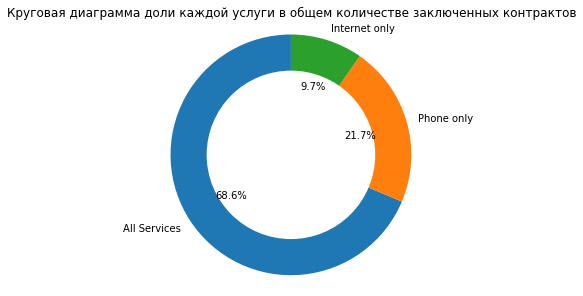

In [35]:
labels = ['All Services', 'Phone only', 'Internet only' ]
sizes = df_full['Services'].value_counts().values
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title("Круговая диаграмма доли каждой услуги в общем количестве заключенных контрактов")
plt.show()

Из круговой диаграммы видно, что больше всего клиентов (68.6%) пользуются всеми сервисами оператора, а только интернетом лишь 9.7%

In [36]:
fig = px.histogram (df_full, x="Services",nbins = 5,
                    title = 'Столбчатая диаграмма доли каждой услуги в общем количестве заключенных контрактов' )
fig.update_xaxes(categoryorder='total descending')
fig.show()

Столбчатая диагтрамма показывает абсолютное значение числа пользователей разного вида услуг, всеми сервисами пользуются ~5000 пользователей, только интернетом ~700 пользователей

Найдем долю пользователей, которые перестали пользоваться услугами компании.

In [37]:
Churn_rate = round((df_full['Churn'].value_counts()[1] / df_full['Churn'].count()) * 100, 2)
Churn_rate

26.54

26.54% клиентов от общего числа пользователей перестало пользоваться услугами компании

Доля ушедших пользователей, в зависимости от типов предоставляемых услуг:

In [38]:
df_full.query('Churn == 1')['Services'].value_counts()/df_full['Services'].value_counts()

All Services     0.328025
Only Internet    0.249267
Only Phone       0.074050
Name: Services, dtype: float64

In [39]:
dd = df_full.query('EndDate != "active"').groupby(['EndDate', 'Services']).count().reset_index()
fig = px.bar (dd, x='EndDate', y = 'Churn', color ='Services',
              title = 'График зависимости ушедших пользователей от времени с учетом услуг' )
fig.show()

Клиенты постепенно уходят, равномерно по всем типам услуг. Значительных аномалий не обнаружено.

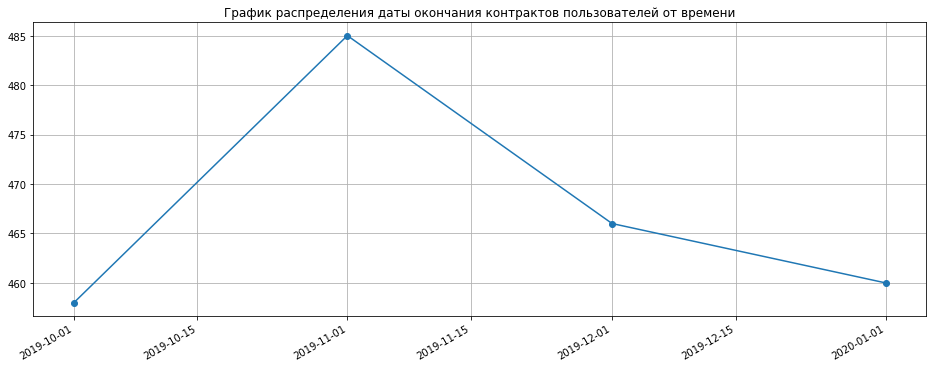

In [40]:
df_full.loc[df_full['EndDate'] != 'active','EndDate'].value_counts().plot(style='o-', grid=True,figsize=(16, 6))
plt.title("График распределения даты окончания контрактов пользователей от времени")
plt.show()

In [41]:
df_full.loc[df_full['EndDate'] != 'active','EndDate'].value_counts().describe()

count      4.000000
mean     467.250000
std       12.311918
min      458.000000
25%      459.500000
50%      463.000000
75%      470.750000
max      485.000000
Name: EndDate, dtype: float64

В совокупности услуг также равномерно,  463 клиента ежимесячно перестают пользоваться услугами компании с амплитудой ~20 клиентов

Исследуем количество новых клиентов

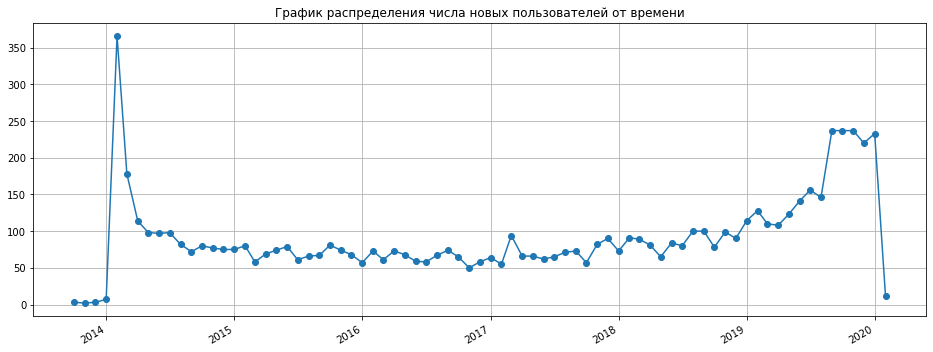

In [42]:
df_full['BeginDate'].value_counts().plot(style='o-', grid=True,figsize=(16, 6))
plt.title("График распределения числа новых пользователей от времени")
plt.show()

В 2014 году произошел резкий рост числа новых клиентов компании - скорее всего в виду промо-акций чтобы о компании узнали и начали пользоваться на выгодных условиях.  
Промо-акция длилась около четверти года и далее число новых клиентов пошло на спад.  
Со 2й четверти 2014года по середину 2019года плавный набор новых клиентов, примерно 75 клиентов в месяц.  
С середины 2019 года по январь 2020года - увеличение ежемесячного прироста пользователей примерно в 3 раза - возможно новые акции в связи с начавшимся оттоком клиентов.  
Февраль 2020 года - резкое уменьшение числа вновь зарегистрированных пользователей. Это связано с тем, что данные выгружены на момент 1 февраля 2020 и представлены на графике всего за 1 день.

Введем новый признак - количество дней, сколько пользователь являлся клиентом компании.

### Анализ периода пользования услугами и затрат

In [43]:
df_full['lasted'] = df_full.loc[df_full['EndDate'] != 'active','EndDate'] - df_full['BeginDate']

In [44]:
df_full['lasted'].value_counts()

31 days      198
30 days      182
61 days      123
153 days      64
92 days       63
            ... 
1705 days      2
1340 days      1
1917 days      1
1218 days      1
2161 days      1
Name: lasted, Length: 131, dtype: int64

In [45]:
fig = px.histogram (df_full['lasted'].dt.days, x="lasted",
                    nbins = 100, title = 'Количество ушедших пользователей и период их пользования услугами компании' )
fig.show()

На гистограмме видно, что множество клиентов перестают пользоваться услугами компании менее чем через 100 дней (3 месяца)

In [46]:
fig = px.histogram (df_full[df_full['lasted'].dt.days<100]['lasted'].dt.days,
                    x="lasted", nbins =10, title = 'Количество полизователей, ушедших менее чем через 100 дней' )
fig.show()

Большинство из пользователей, которые ушли менее чем через 100 дней, прекращают пользоваться услугами уже после первого месяца. Возможно, это связано с промо-акциями, которые распространяются только на первый месяц пользования услугами.

In [47]:
fig = px.histogram (df_full['MonthlyCharges'],
                    x="MonthlyCharges", nbins =50, title = 'Ежемесячные траты на услуги' )
fig.show()

На данной гистограмме мы наблюдаем резкий всплеск у самых дешевых тарифов по ежемесячной плате, изучим этот период.

In [48]:
df_full['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [49]:
fig = px.histogram (df_full.query('MonthlyCharges <60'),
                    x="MonthlyCharges", nbins =50, title = 'Ежемесячные траты на услуги, не превышающие 60' )
fig.show()

На гистограмме мы видим гибкость тарифных планов оператора, в основном клиенты пользуются самым дешевым - около 20.

In [50]:
fig = px.histogram (df_full['TotalCharges'],
                    x="TotalCharges", nbins =50, title = 'Суммарные траты на услуги' )
fig.show()

Суммарные траты на услуги вероятнее всего подчиняются показательному(отрицательно экспоненциальному) распределению.

In [51]:
fig = px.histogram (df_full.query('Churn == 1')['TotalCharges'],
                    x="TotalCharges", nbins =50, title = 'Суммарные траты на услуги' )
fig.show()

Суммарные траты на услуги ушедших клиентов не отличаются по распределению.

### Анализ гендерной принадлежности

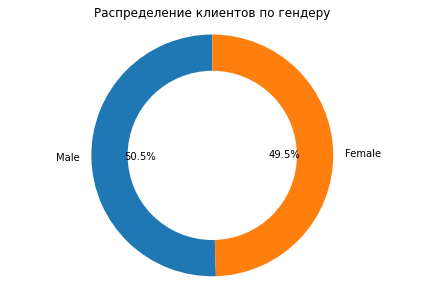

In [52]:
labels = ['Male', 'Female']
sizes = df_full['gender'].value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title("Распределение клиентов по гендеру")
plt.show()
plt.show()

Среди общего числа клиентов гендерное равенство.

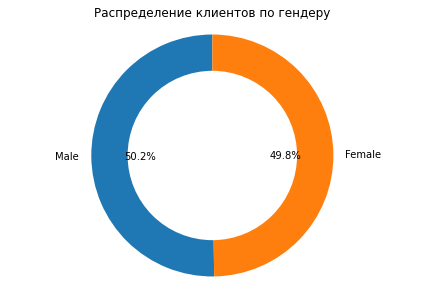

In [53]:
labels = ['Male', 'Female']
sizes = df_full.query('Churn == 1')['gender'].value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title("Распределение клиентов по гендеру")
plt.show()
plt.show()

Среди ушедших клиентов также нет явной принадлежности.

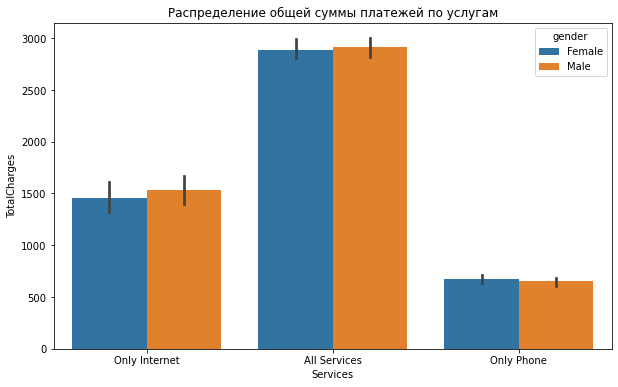

In [54]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Services", y="TotalCharges", hue="gender",  data=df_full)
plt.title("Распределение общей суммы платежей по услугам")
plt.show()

В зависимости от предоставляемых услуг, также гендерное равенство.

### Анализ предоставляемых услуг, возраста и наличия детей

OnlineSecurity 
 No     5024
Yes    2019
Name: OnlineSecurity, dtype: int64


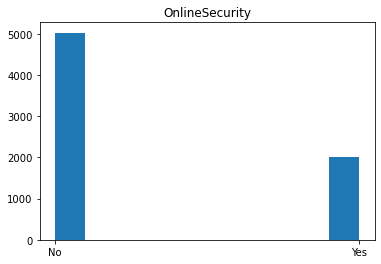

OnlineBackup 
 No     4614
Yes    2429
Name: OnlineBackup, dtype: int64


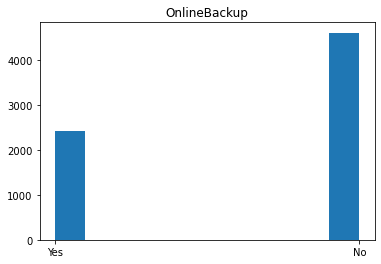

DeviceProtection 
 No     4621
Yes    2422
Name: DeviceProtection, dtype: int64


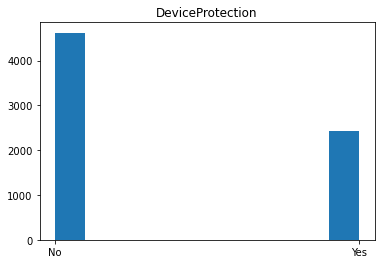

TechSupport 
 No     4999
Yes    2044
Name: TechSupport, dtype: int64


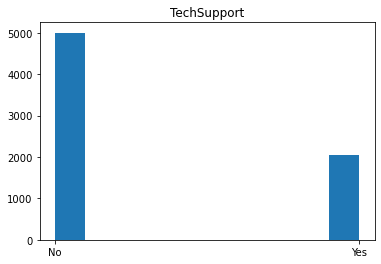

StreamingTV 
 No     4336
Yes    2707
Name: StreamingTV, dtype: int64


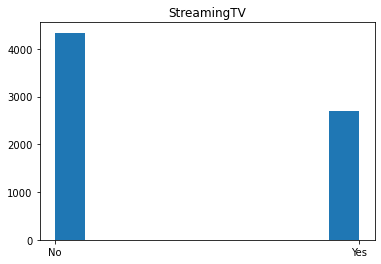

StreamingMovies 
 No     4311
Yes    2732
Name: StreamingMovies, dtype: int64


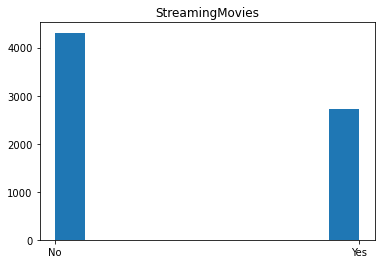

SeniorCitizen 
 0    5901
1    1142
Name: SeniorCitizen, dtype: int64


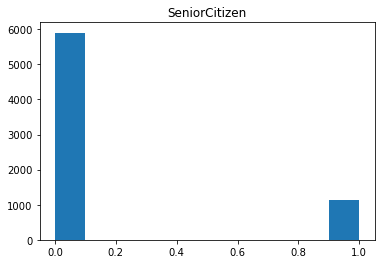

Partner 
 No     3641
Yes    3402
Name: Partner, dtype: int64


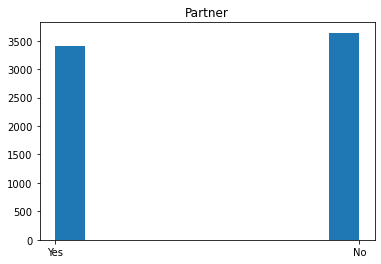

Dependents 
 No     4933
Yes    2110
Name: Dependents, dtype: int64


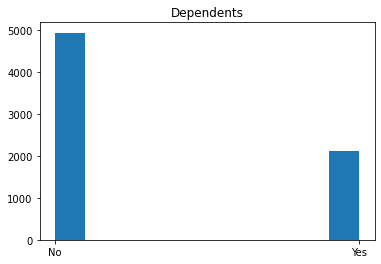

MultipleLines 
 No     4072
Yes    2971
Name: MultipleLines, dtype: int64


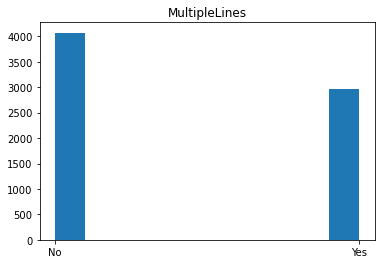

PaperlessBilling 
 Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64


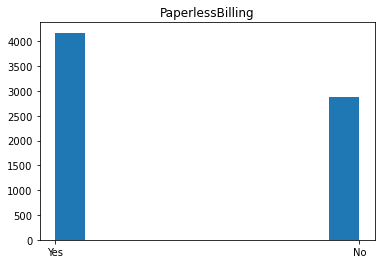

In [55]:
binary_col = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',\
              'StreamingMovies','SeniorCitizen','Partner','Dependents','MultipleLines','PaperlessBilling']
for i in binary_col:
  print(i,'\n',df_full[i].value_counts())
  plt.hist(df_full[i])
  plt.title(i)
  plt.show()

OnlineSecurity 
 No     5024
Yes    2019
Name: OnlineSecurity, dtype: int64


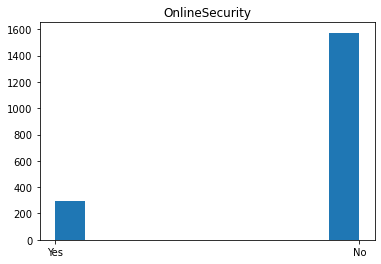

OnlineBackup 
 No     4614
Yes    2429
Name: OnlineBackup, dtype: int64


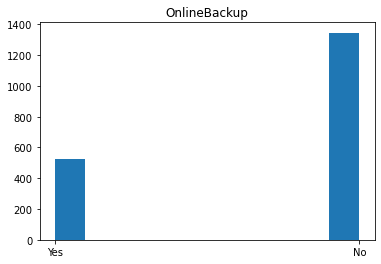

DeviceProtection 
 No     4621
Yes    2422
Name: DeviceProtection, dtype: int64


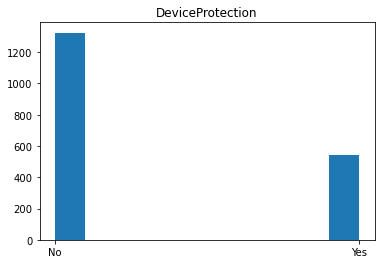

TechSupport 
 No     4999
Yes    2044
Name: TechSupport, dtype: int64


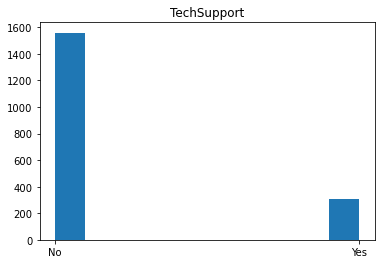

StreamingTV 
 No     4336
Yes    2707
Name: StreamingTV, dtype: int64


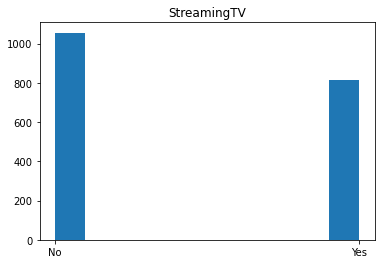

StreamingMovies 
 No     4311
Yes    2732
Name: StreamingMovies, dtype: int64


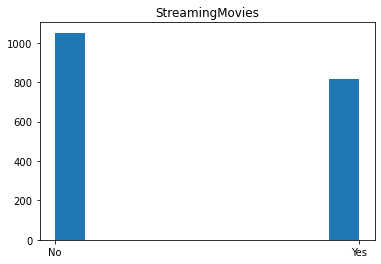

SeniorCitizen 
 0    5901
1    1142
Name: SeniorCitizen, dtype: int64


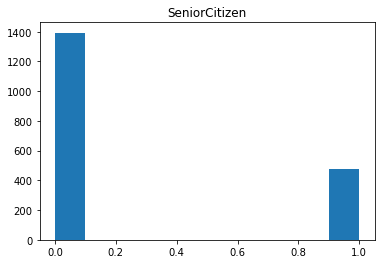

Partner 
 No     3641
Yes    3402
Name: Partner, dtype: int64


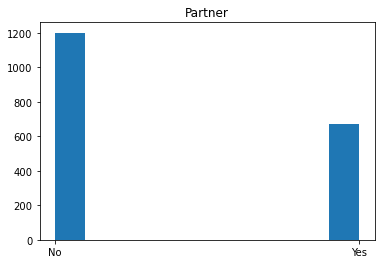

Dependents 
 No     4933
Yes    2110
Name: Dependents, dtype: int64


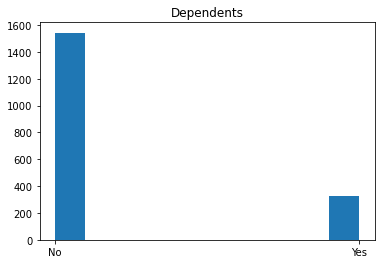

MultipleLines 
 No     4072
Yes    2971
Name: MultipleLines, dtype: int64


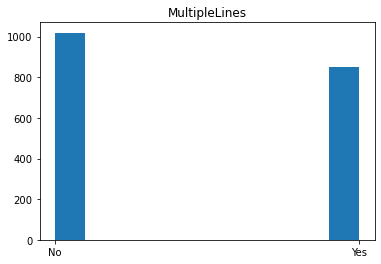

PaperlessBilling 
 Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64


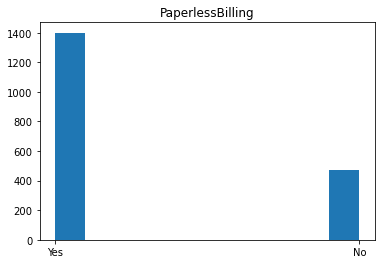

In [56]:
binary_col = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',\
              'StreamingMovies','SeniorCitizen','Partner','Dependents','MultipleLines','PaperlessBilling']
for i in binary_col:
  print(i,'\n',df_full[i].value_counts())
  plt.hist(df_full.query('Churn == 1')[i])
  plt.title(i)
  plt.show()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


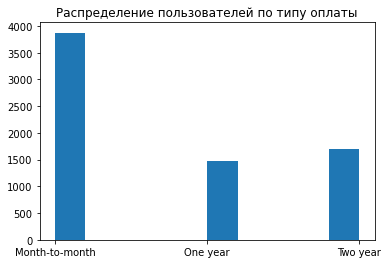

In [57]:
print(df_full['Type'].value_counts())
plt.title('Распределение пользователей по типу оплаты')
plt.hist(df_full['Type']);

Большинство пользователей предпочитают ежемесячную оплату

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64


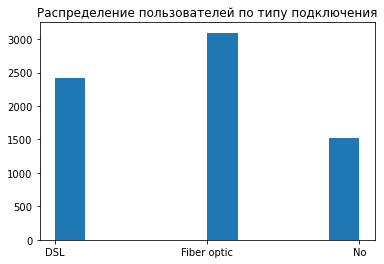

In [58]:
print(df_full['InternetService'].value_counts())
plt.title('Распределение пользователей по типу подключения')
plt.hist(df_full['InternetService']);

Большинство пользователей предпочитают оптоволоконное подключение

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


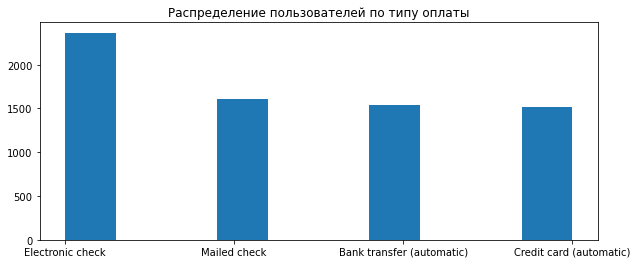

In [59]:
print(df_full['PaymentMethod'].value_counts())
plt.figure(figsize=(10,4))
plt.title('Распределение пользователей по типу оплаты')
plt.hist(df_full['PaymentMethod']);

Большинство пользователей предпочитают электронную оплату

### Вывод по разделу 4

1. Данные были подготовлены (удалены пропуски, изменены типы), добавлены два новых признака - сколько дней ушедший клиент пользовался нашими услугами (lasted) и целевой признак: ушел клиент от нас или нет (Churn).
2. Клиенты пользуются в основном всеми услугами компании(без доп.услуг):
+ всеми услугами: 68,6% клиентов;
+ только интернетом: 9,7% клиентов;
+ только телефоном: 21,7% клиентов.
3. Перестало пользоваться услугами компании 26.54% клиентов от общего числа пользователей.
Из них от общего числа пользователей по категории:
+ всеми услугами: 32,8% клиентов;
+ только интернетом: 24,9% клиентов;
+ только телефоном: 7,4% клиентов.  
4. Клиенты постепенно уходят, равномерно по всем типам услуг не зависимо от временного периода.  
Это говорит о том, что проблема заключена не в какой-либо конкретной услуге, предоставляемой оператором, а в целом клиенты не хотят быть пользователями данного телеком-провайдера.
5. Анализ новых пользователей показал, что:
+ в 2014 году произошел резкий рост числа новых клиентов компании - скорее всего в виду промо-акций чтобы о компании узнали и начали пользоваться на выгодных условиях.  
+ Промо-акция длилась около четверти года и далее число новых клиентов пошло на спад.  
+ Со 2й четверти 2014года по середину 2019года плавный набор новых клиентов, примерно 75 клиентов в месяц.  
+ С середины 2019 года по январь 2020года - увеличение ежемесячного прироста пользователей примерно в 3 раза - возможно новые акции в связи с начавшимся оттоком клиентов.  
+ Февраль 2020 года - резкое уменьшение числа вновь зарегистрированных пользователей. Это связано с тем, что данные выгружены на момент 1 февраля 2020.
6. Большинство из пользователей, уходят менее чем через 100 дней, наибольший пик оттока уже после первого месяца. Возможно, это связано с промо-акциями, которые распространяются только на первый месяц пользования услугами.
7. Уходят не только новые клиенты, но и те, которые пользовались услугами длительный срок.
8. Гендерная принадлежность клиентов практически 50 на 50. В целом, распределение платежей от клиентов в зависимости от гендера одинаковое с небольшим перевесом в сторону пользователей-мужчин. Кроме телефона - клиенты женского пола приносят чуть больше прибыли от телефонной связи чем мужчины.
9. Анализ предоставляемых услуг, возраста и наличия детей не выявил явного дисбаланса. Самые популярные услуги это онлайн безопасность и техническая поддержка, а также большенство предпочитает получать чеки онлайн. Самая непопулярная услуга это мультилинии,с ростом интернета доп услуги телефонии уже не так востребованы.
10. Большинство пользователей предпочитают ежемесячную оплату, оптоволоконне подключение и электронные чеки.


******************************************************************************

## Подготовка данных к расчету модели

### Кодирование категориальных переменных

Бинарные категориальные переменные закодируем вручную, Yes No переводим в 1 и 0 соответсвенно

In [60]:
df = df_full

In [61]:
df['MultipleLines'] = pd.Series(np.where(df['MultipleLines'].values == 'Yes', 1, 0),df.index)
df['Dependents'] = pd.Series(np.where(df['Dependents'].values == 'Yes', 1, 0),df.index)
df['Partner'] = pd.Series(np.where(df['Partner'].values == 'Yes', 1, 0),df.index)
df['gender'] = pd.Series(np.where(df['gender'].values == 'Female', 1, 0),df.index)
df['StreamingMovies'] = pd.Series(np.where(df['StreamingMovies'].values == 'Yes', 1, 0),df.index)
df['StreamingTV'] = pd.Series(np.where(df['StreamingTV'].values == 'Yes', 1, 0),df.index)
df['TechSupport'] = pd.Series(np.where(df['TechSupport'].values == 'Yes', 1, 0),df.index)
df['DeviceProtection'] = pd.Series(np.where(df['DeviceProtection'].values == 'Yes', 1, 0),df.index)
df['OnlineBackup'] = pd.Series(np.where(df['OnlineBackup'].values == 'Yes', 1, 0),df.index)
df['OnlineSecurity'] = pd.Series(np.where(df['OnlineSecurity'].values == 'Yes', 1, 0),df.index)
df['PaperlessBilling'] = pd.Series(np.where(df['PaperlessBilling'].values == 'Yes',1,0),df.index)

In [62]:
df.head(1)

BeginDate EndDate            Type  PaperlessBilling  \
customerID                                                        
7590-VHVEG 2020-01-01  active  Month-to-month                 1   

               PaymentMethod  MonthlyCharges  TotalCharges  MultipleLines  \
customerID                                                                  
7590-VHVEG  Electronic check           29.85         29.85              0   

            gender  SeniorCitizen  ...  InternetService  OnlineSecurity  \
customerID                         ...                                    
7590-VHVEG       1              0  ...              DSL               0   

           OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
customerID                                                            
7590-VHVEG            1                 0            0            0   

            StreamingMovies       Services  Churn lasted  
customerID                                                
7590-VHVEG                0  Only Internet      0    NaT  

[1 rows x 22 columns]

Остальные переменные закодируем техникой OHE (OneHotEncoder)

In [63]:
df = pd.get_dummies(df_full, columns = ['Type', 'InternetService','PaymentMethod'], drop_first = True)

### Формирование конечного датасета для моделирования

Столбец `Services` удалим, т.к. он коррелирует с другими признаками и был нужен для исследовательского анализа

In [64]:
df.drop('Services', axis = 1, inplace = True)

Значение `active` столбца `EndDate` изменим на дату выгрузки датасета (2020-02-01), пересчитаем столбец `lasted` и переименуем его в `duration`, чтобы лучше отображать значения данного столбца после изменений.

In [65]:
df['EndDate'] = df['EndDate'].replace('active', '2020-02-01')

In [66]:
df.head(1)

BeginDate     EndDate  PaperlessBilling  MonthlyCharges  \
customerID                                                            
7590-VHVEG 2020-01-01  2020-02-01                 1           29.85   

            TotalCharges  MultipleLines  gender  SeniorCitizen  Partner  \
customerID                                                                
7590-VHVEG         29.85              0       1              0        1   

            Dependents  ...  StreamingMovies  Churn  lasted  Type_One year  \
customerID              ...                                                  
7590-VHVEG           0  ...                0      0     NaT              0   

            Type_Two year  InternetService_Fiber optic  InternetService_No  \
customerID                                                                   
7590-VHVEG              0                            0                   0   

           PaymentMethod_Credit card (automatic)  \
customerID                                         
7590-VHVEG                                     0   

            PaymentMethod_Electronic check  PaymentMethod_Mailed check  
customerID                                                              
7590-VHVEG                               1                           0  

[1 rows x 25 columns]

In [67]:
df['lasted'] = (pd.to_datetime(df['EndDate']) - df['BeginDate']).dt.days

In [68]:
df.rename({'lasted': 'duration'}, axis=1, inplace=True)

In [69]:
df.head(1)

BeginDate     EndDate  PaperlessBilling  MonthlyCharges  \
customerID                                                            
7590-VHVEG 2020-01-01  2020-02-01                 1           29.85   

            TotalCharges  MultipleLines  gender  SeniorCitizen  Partner  \
customerID                                                                
7590-VHVEG         29.85              0       1              0        1   

            Dependents  ...  StreamingMovies  Churn  duration  Type_One year  \
customerID              ...                                                    
7590-VHVEG           0  ...                0      0        31              0   

            Type_Two year  InternetService_Fiber optic  InternetService_No  \
customerID                                                                   
7590-VHVEG              0                            0                   0   

            PaymentMethod_Credit card (automatic)  \
customerID                                          
7590-VHVEG                                      0   

            PaymentMethod_Electronic check  PaymentMethod_Mailed check  
customerID                                                              
7590-VHVEG                               1                           0  

[1 rows x 25 columns]

Удалим столбцы `EndDate` и `BeginDate`, т.к. они зависимы от столбца `duration`

In [70]:
df.drop('EndDate', axis = 1, inplace = True)
df.drop('BeginDate', axis = 1, inplace = True)

In [71]:
df['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

Датасет для моделирования:

In [72]:
df

PaperlessBilling  MonthlyCharges  TotalCharges  MultipleLines  \
customerID                                                                  
7590-VHVEG                 1           29.85         29.85              0   
5575-GNVDE                 0           56.95       1889.50              0   
3668-QPYBK                 1           53.85        108.15              0   
7795-CFOCW                 0           42.30       1840.75              0   
9237-HQITU                 1           70.70        151.65              0   
...                      ...             ...           ...            ...   
6840-RESVB                 1           84.80       1990.50              1   
2234-XADUH                 1          103.20       7362.90              1   
4801-JZAZL                 1           29.60        346.45              0   
8361-LTMKD                 1           74.40        306.60              1   
3186-AJIEK                 1          105.65       6844.50              0   

            gender  SeniorCitizen  Partner  Dependents  OnlineSecurity  \
customerID                                                               
7590-VHVEG       1              0        1           0               0   
5575-GNVDE       0              0        0           0               1   
3668-QPYBK       0              0        0           0               1   
7795-CFOCW       0              0        0           0               1   
9237-HQITU       1              0        0           0               0   
...            ...            ...      ...         ...             ...   
6840-RESVB       0              0        1           1               1   
2234-XADUH       1              0        1           1               0   
4801-JZAZL       1              0        1           1               1   
8361-LTMKD       0              1        1           0               0   
3186-AJIEK       0              0        0           0               1   

            OnlineBackup  ...  StreamingMovies  Churn  duration  \
customerID                ...                                     
7590-VHVEG             1  ...                0      0        31   
5575-GNVDE             0  ...                0      0      1036   
3668-QPYBK             1  ...                0      1        61   
7795-CFOCW             0  ...                0      0      1371   
9237-HQITU             0  ...                0      1        61   
...                  ...  ...              ...    ...       ...   
6840-RESVB             0  ...                1      0       730   
2234-XADUH             1  ...                1      0      2191   
4801-JZAZL             0  ...                0      0       337   
8361-LTMKD             0  ...                0      1       123   
3186-AJIEK             0  ...                1      0      2010   

            Type_One year  Type_Two year  InternetService_Fiber optic  \
customerID                                                              
7590-VHVEG              0              0                            0   
5575-GNVDE              1              0                            0   
3668-QPYBK              0              0                            0   
7795-CFOCW              1              0                            0   
9237-HQITU              0              0                            1   
...                   ...            ...                          ...   
6840-RESVB              1              0                            0   
2234-XADUH              1              0                            1   
4801-JZAZL              0              0                            0   
8361-LTMKD              0              0                            1   
3186-AJIEK              0              1                            1   

            InternetService_No  PaymentMethod_Credit card (automatic)  \
customerID                                                              
7590-VHVEG                   0                                      0   
5575-G

Выводы по разделу 5:  
Данные подготовлены для моделирования, бинарные категориальные переменные закодированны как 0 и 1, остальные преобразованны техникой OneHotEncoder. Из датасета удалены лишние столбцы. В целевом признаке наблюдается дисбаланс, необходимо использовать внутри модели class_weight,а  в случае плохих метрик использовать сэмплирование.

## Моделирование

### Разделение данных 

In [73]:
train_df, test_df = train_test_split(df, test_size = 0.3, random_state = 42)

In [74]:
features_train = train_df.drop('Churn', axis = 1)
features_test = test_df.drop('Churn', axis = 1)

target_train = train_df['Churn']
target_test = test_df['Churn']
print('features_train', len(features_train))
print('features_test', len(features_test))

features_train 4930
features_test 2113


Построим корреляционную матрицу:

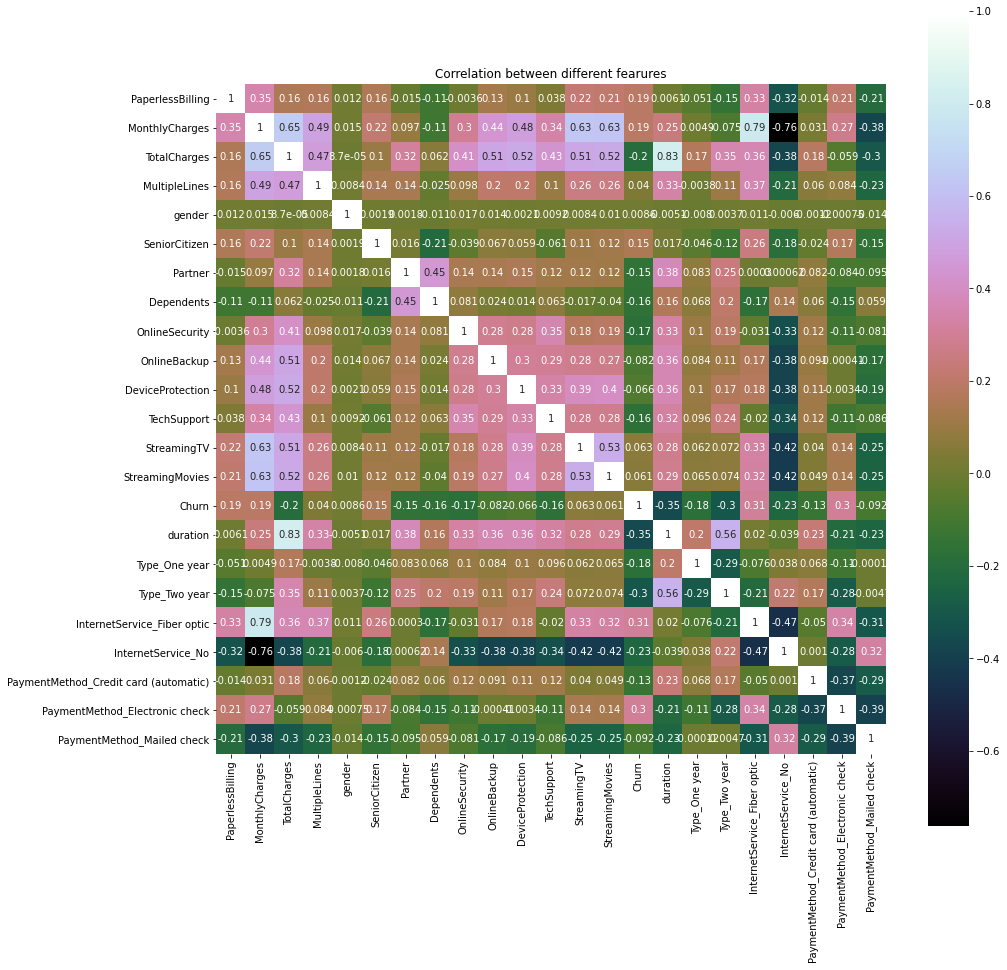

In [75]:
correlation = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different fearures')
plt.show()

Данные в норме. Наибольший коэффициент корреляции между `duration` и  `TotalCharges`, что логично, чем больше клиент пользуется услугами компании, тем большую сумму он тратит

### Модель RandomForestClassifier

In [76]:
%%time
RFC = RandomForestClassifier(class_weight = 'balanced', random_state = 13)

RFC.fit(features_train, target_train)

RFC_Prediction_Proba = RFC.predict_proba(features_train)[:,1]
RFC_Predictions = RFC.predict(features_train)

RFC_roc = roc_auc_score(target_train, RFC_Prediction_Proba)
RFC_acc = accuracy_score(target_train, RFC_Predictions)
print('roc_auc =', RFC_roc )
print('RFC_acc =', RFC_acc )


roc_auc = 0.99998651038541
RFC_acc = 0.9987829614604462
Wall time: 915 ms


Исследуем признаки

Feature importances:
 1. feature 'duration' (0.1970)
 2. feature 'TotalCharges' (0.1644)
 3. feature 'MonthlyCharges' (0.1603)
 4. feature 'Type_Two year' (0.0671)
 5. feature 'InternetService_Fiber optic' (0.0494)
 6. feature 'PaymentMethod_Electronic check' (0.0343)
 7. feature 'Type_One year' (0.0328)
 8. feature 'InternetService_No' (0.0252)
 9. feature 'gender' (0.0244)
10. feature 'PaperlessBilling' (0.0239)
11. feature 'OnlineSecurity' (0.0237)
12. feature 'Partner' (0.0215)
13. feature 'TechSupport' (0.0214)
14. feature 'OnlineBackup' (0.0202)
15. feature 'Dependents' (0.0200)
16. feature 'MultipleLines' (0.0187)
17. feature 'StreamingMovies' (0.0183)
18. feature 'DeviceProtection' (0.0178)
19. feature 'SeniorCitizen' (0.0166)
20. feature 'StreamingTV' (0.0158)
21. feature 'PaymentMethod_Credit card (automatic)' (0.0137)
22. feature 'PaymentMethod_Mailed check' (0.0133)


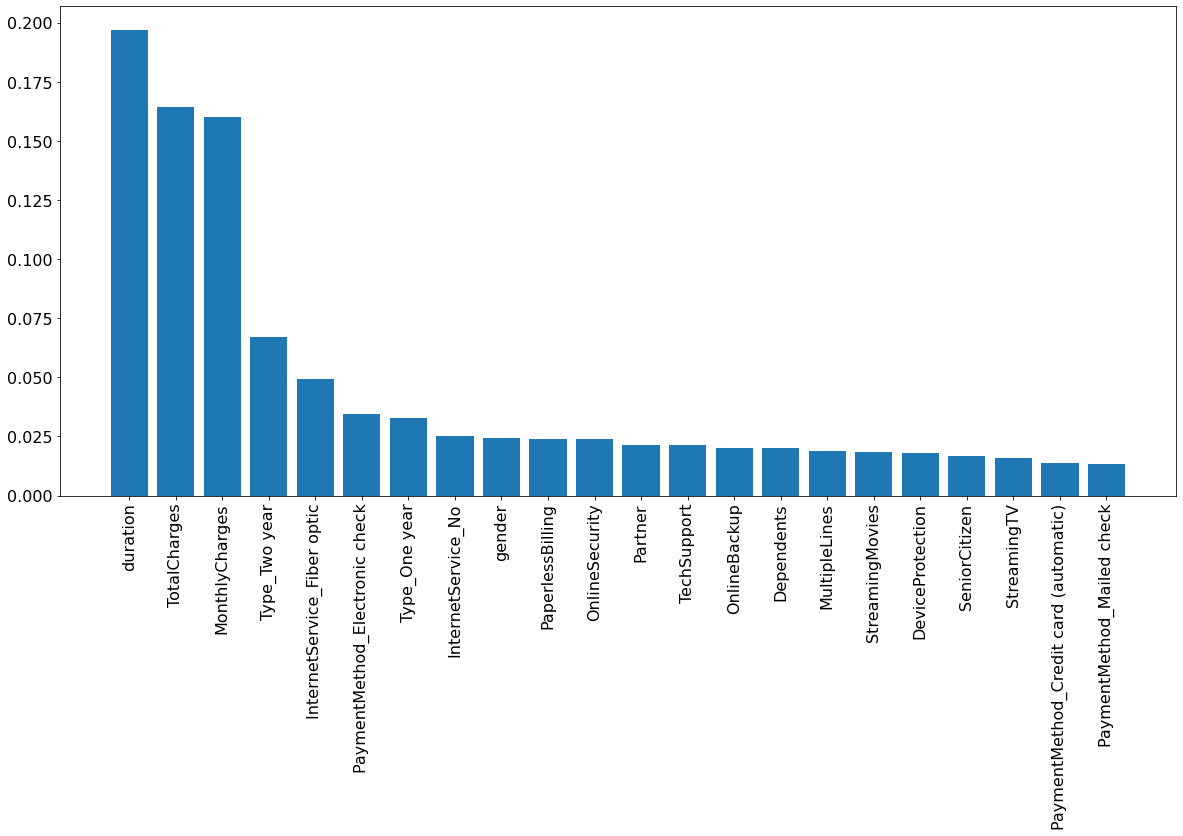

In [77]:
feature_import2 = RFC.feature_importances_
col_names = features_train.columns
indices = np.argsort(feature_import2)[::-1]
print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, col_names[idx], feature_import2[idx]))
d1 = pd.Series(data =feature_import2, index =col_names  ).sort_values(ascending=False)
plt.figure(figsize=(20,9))
plt.bar(d1.index,d1.values)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=90);

Для случайного леса наибольшей значимостью обладает 15 из 22 features :

Feature importances:
1. feature 'duration' (0.1970)
2. feature 'TotalCharges' (0.1644)
3. feature 'MonthlyCharges' (0.1603)
4. feature 'Type_Two year' (0.0671)
5. feature 'InternetService_Fiber optic' (0.0494)
6. feature 'PaymentMethod_Electronic check' (0.0343)
7. feature 'Type_One year' (0.0328)
8. feature 'InternetService_No' (0.0252)
9. feature 'gender' (0.0244)
10. feature 'PaperlessBilling' (0.0239)
11. feature 'OnlineSecurity' (0.0237)
12. feature 'Partner' (0.0215)
13. feature 'TechSupport' (0.0214)
14. feature 'OnlineBackup' (0.0202)
15. feature 'Dependents' (0.0200)

In [78]:
feature_importances = d1.iloc[:15].index
feature_importances

Index(['duration', 'TotalCharges', 'MonthlyCharges', 'Type_Two year',
       'InternetService_Fiber optic', 'PaymentMethod_Electronic check',
       'Type_One year', 'InternetService_No', 'gender', 'PaperlessBilling',
       'OnlineSecurity', 'Partner', 'TechSupport', 'OnlineBackup',
       'Dependents'],
      dtype='object')

In [79]:
rfc_X_train = features_train[feature_importances]

In [80]:
rfc_X_test = features_test[feature_importances]

In [81]:
RFC_2_fi_CV = GridSearchCV(RandomForestClassifier(criterion = 'entropy', class_weight='balanced'),{
                            'max_depth': range(3,15,3),
                            'n_estimators': range(10,100, 10),
                            'min_samples_split' : range(4,28,4),
                            'min_samples_leaf' : range(3,13,2)},
                             cv = 5,
                             scoring = 'roc_auc',
                              n_jobs=-1)

In [82]:
%%time
RFC_2_fi_CV.fit(rfc_X_train,target_train)

Wall time: 3min 56s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy'),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 15, 3),
                         'min_samples_leaf': range(3, 13, 2),
                         'min_samples_split': range(4, 28, 4),
                         'n_estimators': range(10, 100, 10)},
             scoring='roc_auc')

In [83]:
best_params_RFC_2_fi_CV= RFC_2_fi_CV.best_params_
print('best_params_RFC_2_fi_CV =', best_params_RFC_2_fi_CV)

best_params_RFC_2_fi_CV = {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 20, 'n_estimators': 90}


In [84]:
RFC_2_fi_CV.best_score_

0.8520412336093216

In [85]:
%%time
RFC_2_fi_CV = RandomForestClassifier(**best_params_RFC_2_fi_CV, random_state =13)

RFC_2_fi_CV.fit(rfc_X_train, target_train)

RFC_2_fi_CV_Prediction_Proba = RFC_2_fi_CV.predict_proba(rfc_X_train)[:,1]
RFC_2_fi_CV_Predictions = RFC_2_fi_CV.predict(rfc_X_train)


RFC_2_fi_CV_roc = roc_auc_score(target_train, RFC_2_fi_CV_Prediction_Proba)
RFC_2_fi_CV_acc = accuracy_score(target_train, RFC_2_fi_CV_Predictions)
print('RFC_2_fi_CV_roc =',RFC_2_fi_CV_roc )
print('RFC_2_fi_CV_acc =',RFC_2_fi_CV_acc )

RFC_2_fi_CV_roc = 0.9070040840604802
RFC_2_fi_CV_acc = 0.8456389452332658
Wall time: 453 ms


### Модель CatBoostClassifier

In [86]:
train_dataset = Pool(features_train, target_train)
test_dataset = Pool(features_test, target_test)

In [87]:
%%time
CB = CatBoostClassifier(loss_function = 'CrossEntropy',learning_rate = 0.03, random_state = 13)
CB.fit(train_dataset, plot=True, verbose = False)
CB_Prediction_Proba = CB.predict_proba(features_train)[:,1]
CB_Prediction = CB.predict(features_train)
CB_roc = roc_auc_score(target_train, CB_Prediction_Proba)
CB_acc = accuracy_score(target_train, CB_Prediction)
print('CB_roc =',CB_roc )
print('CB_acc =',CB_acc )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CB_roc = 0.9763893506396945
CB_acc = 0.9281947261663286
Wall time: 4.92 s


Feature Id  Importances
0                                duration    43.186024
1                          MonthlyCharges    10.522276
2                            TotalCharges     9.612247
3                           Type_Two year     6.746619
4             InternetService_Fiber optic     3.766023
5                           Type_One year     2.742648
6          PaymentMethod_Electronic check     2.321668
7                        PaperlessBilling     2.166017
8                           MultipleLines     1.859271
9                             TechSupport     1.747960
10                                 gender     1.740231
11             PaymentMethod_Mailed check     1.590470
12                        StreamingMovies     1.575955
13                         OnlineSecurity     1.445840
14                          SeniorCitizen     1.296241
15                                Partner     1.277115
16  PaymentMethod_Credit card (automatic)     1.252366
17                             Dependents     1.244025
18                           OnlineBackup     1.055382
19                     InternetService_No     1.039079
20                       DeviceProtection     1.020824
21                            StreamingTV     0.791718

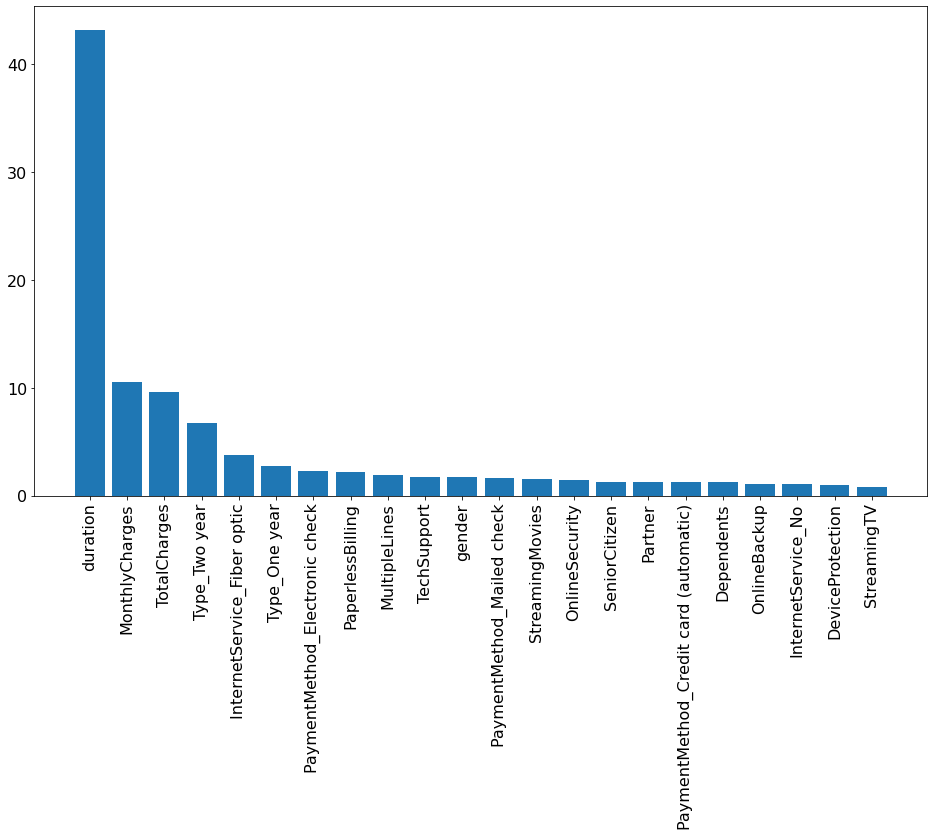

In [88]:
#feature Importance
feature_import = CB.get_feature_importance(train_dataset, prettified = True)
plt.figure(figsize=(16,9))
plt.bar(feature_import['Feature Id'],feature_import['Importances'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=90);
feature_import

In [89]:
CB_features = feature_import.set_index('Feature Id').query('Importances > 1.5')
CB_features

Importances
Feature Id                                 
duration                          43.186024
MonthlyCharges                    10.522276
TotalCharges                       9.612247
Type_Two year                      6.746619
InternetService_Fiber optic        3.766023
Type_One year                      2.742648
PaymentMethod_Electronic check     2.321668
PaperlessBilling                   2.166017
MultipleLines                      1.859271
TechSupport                        1.747960
gender                             1.740231
PaymentMethod_Mailed check         1.590470
StreamingMovies                    1.575955

In [90]:
CB_2_X_train = features_train[CB_features.index]
CB_2_X_test = features_test[CB_features.index]
CB_2_train_dataset = Pool(CB_2_X_train, target_train)
CB_2_test_dataset = Pool(CB_2_X_test, target_test)

### Модель CatBoostClassifier с FI и CV

In [91]:
CB_2_fi = CatBoostClassifier( random_state = 13)
CB_2_fi_CV = GridSearchCV(CB_2_fi,{'iterations': [400,500,600,1000],
                                    'learning_rate' : [0.03],
                                    'depth' : range(3,15,3),
                                    'verbose' : [False]},
                                     cv = 5,
                                     scoring = 'roc_auc',
                                     n_jobs=-1)

In [92]:
%%time
CB_2_fi_CV.fit(CB_2_X_train,target_train)

Wall time: 7min 39s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001872D6E6AC0>,
             n_jobs=-1,
             param_grid={'depth': range(3, 15, 3),
                         'iterations': [400, 500, 600, 1000],
                         'learning_rate': [0.03], 'verbose': [False]},
             scoring='roc_auc')

In [93]:
best_params_CB_2_fi_CV = CB_2_fi_CV.best_params_
best_params_CB_2_fi_CV

{'depth': 6, 'iterations': 1000, 'learning_rate': 0.03, 'verbose': False}

In [94]:
CB_2_fi_CV.best_score_

0.899705246610336

In [95]:
CB_2_fi_CV = CatBoostClassifier(loss_function = 'CrossEntropy',
                                iterations = 1000,
                                depth = 6,
                                learning_rate = 0.03,
                                random_state = 13)

In [96]:
CB_2_fi_CV.fit(CB_2_train_dataset, plot=True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [97]:
CB_2_fi_CV_Prediction_Proba = CB_2_fi_CV.predict_proba(CB_2_X_train)[:,1]
CB_2_fi_CV_Prediction = CB_2_fi_CV.predict(CB_2_X_train)
CB_2_fi_CV_roc = roc_auc_score(target_train, CB_2_fi_CV_Prediction_Proba)
CB_2_fi_CV_acc = accuracy_score(target_train, CB_2_fi_CV_Prediction)
print('CB_2_fi_CV_roc =',CB_2_fi_CV_roc )
print('CB_2_fi_CV_acc =',CB_2_fi_CV_acc )

CB_2_fi_CV_roc = 0.9710289814278809
CB_2_fi_CV_acc = 0.9210953346855983


In [98]:
CB_2_fi_CV_matrix = confusion_matrix(target_train, CB_2_fi_CV_Prediction)

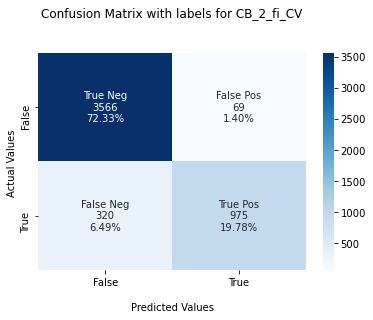

In [99]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                CB_2_fi_CV_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     CB_2_fi_CV_matrix.flatten()/np.sum(CB_2_fi_CV_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(CB_2_fi_CV_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix with labels for CB_2_fi_CV\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Модель CatBoostClassifier_3

In [100]:
CB_3 = CatBoostClassifier(eval_metric='AUC',random_state = 13)
CB_3.fit(train_dataset, verbose=100, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.02036
0:	total: 4.5ms	remaining: 4.49s
100:	total: 568ms	remaining: 5.05s
200:	total: 959ms	remaining: 3.81s
300:	total: 1.38s	remaining: 3.2s
400:	total: 1.91s	remaining: 2.85s
500:	total: 2.34s	remaining: 2.33s
600:	total: 2.79s	remaining: 1.85s
700:	total: 3.26s	remaining: 1.39s
800:	total: 3.72s	remaining: 925ms
900:	total: 4.19s	remaining: 460ms
999:	total: 4.63s	remaining: 0us


In [101]:
CB_3_Prediction_Proba = CB_3.predict_proba(features_train)[:,1]
CB_3_Prediction = CB_3.predict(features_train)
CB_3_roc = roc_auc_score(target_train, CB_3_Prediction_Proba)
CB_3_acc = accuracy_score(target_train, CB_3_Prediction)
print('CB_3_roc =',CB_3_roc )
print('CB_3_acc =',CB_3_acc )

CB_3_roc = 0.9585074325652041
CB_3_acc = 0.8985801217038539


In [102]:
CB_3_matrix = confusion_matrix(target_train, CB_3_Prediction)

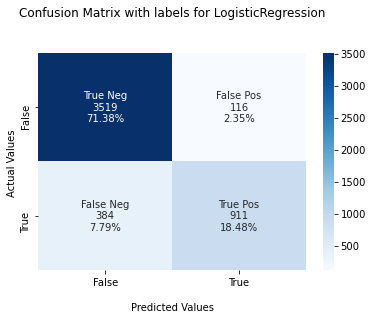

In [103]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                CB_3_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     CB_3_matrix.flatten()/np.sum(CB_3_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(CB_3_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix with labels for LogisticRegression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Модель LogisticRegression

In [104]:
parameters = {
             'penalty' : ['l1','l2'], 
             'C'       : np.logspace(-3,3,7),
             'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],}
LR = LogisticRegression()
LR_CV = GridSearchCV(LR,                    
                     param_grid = parameters,   
                     scoring='roc_auc',        
                     cv=5)                     

In [105]:
%%time
LR_CV.fit(features_train,target_train)

Wall time: 16.7 s


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc')

In [106]:
LR_CV_Prediction_Proba = LR_CV.predict_proba(features_train)[:,1]
LR_CV_Prediction = LR_CV.predict(features_train)
LR_CV_roc = roc_auc_score(target_train, LR_CV_Prediction_Proba)
LR_CV_acc = accuracy_score(target_train, LR_CV_Prediction)
print('LR_CV_roc =',LR_CV_roc )
print('LR_CV_acc =',LR_CV_acc )

LR_CV_roc = 0.843524613235755
LR_CV_acc = 0.8070993914807302


In [107]:
best_params_LR_CV = LR_CV.best_params_
best_params_LR_CV

{'C': 100.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [108]:
LR_CV_matrix = confusion_matrix(target_train, LR_CV_Prediction)

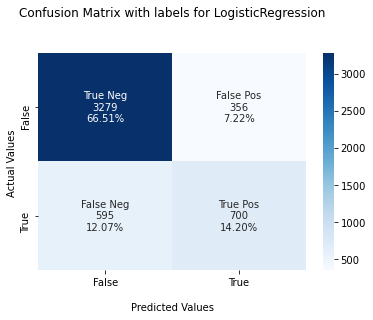

In [109]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                LR_CV_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     LR_CV_matrix.flatten()/np.sum(LR_CV_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(LR_CV_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix with labels for LogisticRegression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Модель LGBMClassifier

In [110]:
estimator = lgb.LGBMClassifier(class_weight='balanced', boosting_type = 'gbdt', objective='binary',
                               random_state=13, reg_alpha = 0, metric = 'auc', max_depth = 1, silent=True)
param_grid = { 'learning_rate': [0.01, 0.1 ,0.5], 'n_estimators': [2,10,60], 'min_child_samples' : [10,50,100]}
LGBM_CV = GridSearchCV(estimator, param_grid, cv=5, scoring='roc_auc')

LGBM_CV.fit(features_train, target_train) 

GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced', max_depth=1,
                                      metric='auc', objective='binary',
                                      random_state=13, reg_alpha=0,
                                      silent=True),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'min_child_samples': [10, 50, 100],
                         'n_estimators': [2, 10, 60]},
             scoring='roc_auc')

In [111]:
LGBM_CV_Prediction_Proba = LGBM_CV.predict_proba(features_train)[:,1]
LGBM_CV_Prediction = LGBM_CV.predict(features_train)
LGBM_CV_roc = roc_auc_score(target_train, LGBM_CV_Prediction_Proba)
LGBM_CV_acc = accuracy_score(target_train, LGBM_CV_Prediction)

print('LGBM_CV_roc =',LGBM_CV_roc )
print('LGBM_CV_acc =',LGBM_CV_acc )

LGBM_CV_roc = 0.8643961273122208
LGBM_CV_acc = 0.7586206896551724


In [112]:
best_params_LGBM_CV = LGBM_CV.best_params_
best_params_LGBM_CV

{'learning_rate': 0.5, 'min_child_samples': 10, 'n_estimators': 60}

In [113]:
LGBM_CV_matrix = confusion_matrix(target_train, LGBM_CV_Prediction)

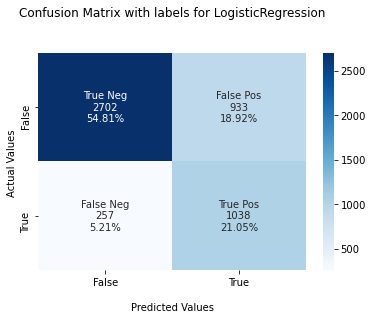

In [114]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                LGBM_CV_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     LGBM_CV_matrix.flatten()/np.sum(LGBM_CV_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(LGBM_CV_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix with labels for LogisticRegression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Вывод по разделу 6:  
Данные разделены на обучающую и тестовую. В обучении модели была использована 5-ступенчатая кросс-валидация. Построена корреляционная матрица, которая показала, что анные в норме. Наибольший коэффициент корреляции между duration и TotalCharges, что логично, чем больше клиент пользуется услугами компании, тем большую сумму он тратит. Для моделей построена Confusion Matrix.   
Обучены модели:
1. Модель RandomForestClassifier с параметром class_weight = 'balanced' для учета дисбаланса целевого признака.
2. Модель RandomForestClassifier с FI и CV, которая учитывает все важные для моделирования признаки (feature Importance), в модели динамически подобраны гиперпараметры.
3. Модель CatBoostClassifier с типичными гиперпараметрами.
4. Модель CatBoostClassifier с FI и CV, которая учитывает все важные для моделирования признаки (feature Importance), в модели динамически подобраны гиперпараметры.
5. Модель CatBoostClassifier со стандартными параметрами, т.к. CatBoost хорошо работает с дефолтными параметрами (моделирование "из коробки")
6. Модель LogisticRegression с CV, с динамически подобранными гиперпараметрами
7. Модель LGBMClassifier с CV, с динамически подобранными гиперпараметрами.

## Тестирование моделей

Протестируем все модели для оценки их эффективности. Качественной оценкой будем считать выполнения двух условий:

Минимальный показатель auc_roc > 0.75
Иделаьный показатель auc_roc > 0.88.

### Модель RandomForestClassifier

In [115]:
random_state = 13

In [116]:
%%time
test_RFC = RandomForestClassifier(class_weight = 'balanced', random_state = random_state)
test_RFC.fit(features_train, target_train)

test_RFC_predict = test_RFC.predict(features_test)
test_RFC_Prediction_Proba = test_RFC.predict_proba(features_test)[:,1]
test_RFC_Prediction = test_RFC.predict(features_test)
test_RFC_roc = roc_auc_score(target_test, test_RFC_Prediction_Proba)
test_RFC_acc = accuracy_score(target_test, test_RFC_Prediction)
print('test_RFC_roc =',test_RFC_roc )
print('test_RFC_acc =',test_RFC_acc )

test_RFC_roc = 0.8579697889710727
test_RFC_acc = 0.8102224325603408
Wall time: 658 ms


### Модель RandomForestClassifier с FI и CV

In [117]:
%%time
test_RFC_2_fi_CV = RandomForestClassifier(**best_params_RFC_2_fi_CV, random_state=random_state)
test_RFC_2_fi_CV.fit(rfc_X_train, target_train)

test_RFC_2_fi_CV_Prediction = test_RFC_2_fi_CV.predict(rfc_X_test)
test_RFC_2_fi_CV_Prediction_Proba = test_RFC_2_fi_CV.predict_proba(rfc_X_test)[:,1]

test_RFC_2_fi_CV_roc = roc_auc_score(target_test, test_RFC_2_fi_CV_Prediction_Proba)
test_RFC_2_fi_CV_acc = accuracy_score(target_test, test_RFC_2_fi_CV_Prediction)
print('test_RFC_2_fi_CV_roc =',test_RFC_2_fi_CV_roc )
print('test_RFC_2_fi_CV_acc =',test_RFC_2_fi_CV_acc )

test_RFC_2_fi_CV_roc = 0.8738705390395592
test_RFC_2_fi_CV_acc = 0.820160908660672
Wall time: 363 ms


### Модель CatBoostClassifier 

In [118]:
%%time
test_CB = CatBoostClassifier(loss_function = 'CrossEntropy',learning_rate = 0.03, random_state = 13)
test_CB.fit(train_dataset, plot=False, verbose = False)
test_CB_Prediction_Proba = test_CB.predict_proba(features_test)[:,1]
test_CB_Prediction = test_CB.predict(features_test)
test_CB_roc = roc_auc_score(target_test, test_CB_Prediction_Proba)
test_CB_acc = accuracy_score(target_test, test_CB_Prediction)
print('test_CB_roc =',test_CB_roc )
print('test_CB_acc =',test_CB_acc )

test_CB_roc = 0.925051449762618
test_CB_acc = 0.869380028395646
Wall time: 3.97 s


### Модель CatBoostClassifier с FI и CV

In [119]:
%%time
test_CB_2_fi_CV = CatBoostClassifier(**best_params_CB_2_fi_CV, random_state = random_state)
test_CB_2_fi_CV.fit(CB_2_test_dataset, plot=False, verbose = False)
test_CB_2_fi_CV_Prediction_Proba = test_CB_2_fi_CV.predict_proba(CB_2_X_test)[:,1]
test_CB_2_fi_CV_Prediction = test_CB_2_fi_CV.predict(CB_2_X_test)
test_CB_2_fi_CV_roc = roc_auc_score(target_test, test_CB_2_fi_CV_Prediction_Proba)
test_CB_2_fi_CV_acc = accuracy_score(target_test, test_CB_2_fi_CV_Prediction)
print('test_CB_2_fi_CV_roc =',test_CB_2_fi_CV_roc )
print('test_CB_2_fi_CV_acc =',test_CB_2_fi_CV_acc )

test_CB_2_fi_CV_roc = 0.9932305922892145
test_CB_2_fi_CV_acc = 0.9616658778987222
Wall time: 2.23 s


### Модель CatBoostClassifier со стандартными параметрами

In [120]:
%%time
test_CB_3 = CatBoostClassifier(eval_metric='AUC',random_state = random_state)
test_CB_3.fit(train_dataset, plot=False, verbose = False)
test_CB_3_Prediction_Proba = test_CB_3.predict_proba(features_test)[:,1]
test_CB_3_Prediction = test_CB_3.predict(features_test)
test_CB_3_roc = roc_auc_score(target_test, test_CB_3_Prediction_Proba)
test_CB_3_acc = accuracy_score(target_test, test_CB_3_Prediction)
print('test_CB_3_roc =',test_CB_3_roc )
print('test_CB_3_acc =',test_CB_3_acc )

test_CB_3_roc = 0.9136872216675385
test_CB_3_acc = 0.8570752484619025
Wall time: 3.92 s


### Модель LogisticRegression с CV

In [121]:
%%time
test_LR_CV = LogisticRegression(**best_params_LR_CV, random_state = random_state)
test_LR_CV.fit(features_train,target_train)
test_LR_CV_Prediction_Proba = test_LR_CV.predict_proba(features_test)[:,1]
test_LR_CV_Prediction = test_LR_CV.predict(features_test)
test_LR_CV_roc = roc_auc_score(target_test, test_LR_CV_Prediction_Proba)
test_LR_CV_acc = accuracy_score(target_test, test_LR_CV_Prediction)
print('test_LR_CV_roc =',test_LR_CV_roc )
print('test_LR_CV_acc =',test_LR_CV_acc )

test_LR_CV_roc = 0.8591980176276284
test_LR_CV_acc = 0.8130619971604354
Wall time: 139 ms


### Модель LGBMClassifier

In [122]:
test_LGBM_CV = lgb.LGBMClassifier(**best_params_LGBM_CV, random_state = random_state)
test_LGBM_CV.fit(features_train,target_train)
test_LGBM_CV_Prediction_Proba = test_LGBM_CV.predict_proba(features_test)[:,1]
test_LGBM_CV_Prediction = test_LGBM_CV.predict(features_test)
test_LGBM_CV_roc = roc_auc_score(target_test, test_LGBM_CV_Prediction_Proba)
test_LGBM_CV_acc = accuracy_score(target_test, test_LGBM_CV_Prediction)
print('test_LGBM_CV_roc =',test_LGBM_CV_roc )
print('test_LGBM_CV_acc =',test_LGBM_CV_acc )

test_LGBM_CV_roc = 0.9098610347005727
test_LGBM_CV_acc = 0.8566019876952201


### Сравнение моделей

In [123]:
index = ['RandomForestClassifier',
         'RandomForestClassifier_fi_CV',
         'CatBoostClassifier',
         'CatBoostClassifier_fi_CV',
         'CatBoostClassifier_default',
         'LogisticRegression',
         'LGBMClassifier',
        ]
data = {'auc-roc':  [test_RFC_roc,
                     test_RFC_2_fi_CV_roc,
                     test_CB_roc,
                     test_CB_2_fi_CV_roc,
                     test_CB_3_roc,
                     test_LR_CV_roc,
                     test_LGBM_CV_roc],
        'accuracy':[test_RFC_acc,
                     test_RFC_2_fi_CV_acc,
                     test_CB_acc,
                     test_CB_2_fi_CV_acc,
                     test_CB_3_acc,
                     test_LR_CV_acc,
                     test_LGBM_CV_acc]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение минимальной задачи'] = scores_data['auc-roc'] > 0.75
scores_data['Выполнение идеальной задачи'] = scores_data['auc-roc'] > 0.88
scores_data.sort_values('auc-roc', ascending=False)

auc-roc  accuracy  \
CatBoostClassifier_fi_CV      0.993231  0.961666   
CatBoostClassifier            0.925051  0.869380   
CatBoostClassifier_default    0.913687  0.857075   
LGBMClassifier                0.909861  0.856602   
RandomForestClassifier_fi_CV  0.873871  0.820161   
LogisticRegression            0.859198  0.813062   
RandomForestClassifier        0.857970  0.810222   

                              Выполнение минимальной задачи  \
CatBoostClassifier_fi_CV                               True   
CatBoostClassifier                                     True   
CatBoostClassifier_default                             True   
LGBMClassifier                                         True   
RandomForestClassifier_fi_CV                           True   
LogisticRegression                                     True   
RandomForestClassifier                                 True   

                              Выполнение идеальной задачи  
CatBoostClassifier_fi_CV                             True  
CatBoostClassifier                                   True  
CatBoostClassifier_default                           True  
LGBMClassifier                                       True  
RandomForestClassifier_fi_CV                        False  
LogisticRegression                                  False  
RandomForestClassifier                              False

AUC-ROC RandomForestClassifier 0.8579697889710727
AUC-ROC RandomForestClassifier with IF and CV 0.8738705390395592
AUC-ROC CatBoostClassifier 0.925051449762618
AUC-ROC CatBoostClassifier with IF and CV 0.9932305922892145
AUC-ROC CatBoostClassifier with default parameters 0.9136872216675385
AUC-ROC LogisticRegression 0.8591980176276284
AUC-ROC LGBMClassifier 0.9098610347005727


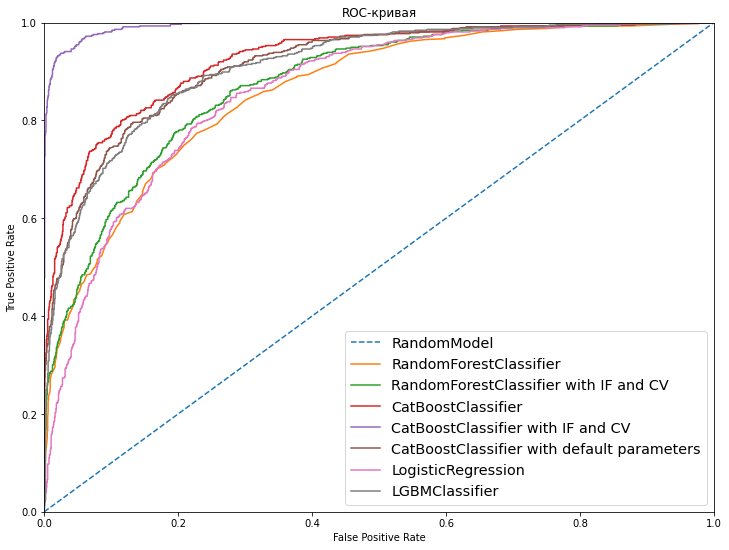

In [124]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = RandomForestClassifier(class_weight = 'balanced', random_state = random_state)
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = RandomForestClassifier(**best_params_RFC_2_fi_CV, random_state=random_state)
model.fit(rfc_X_train, target_train)
probabilities_test = model.predict_proba(rfc_X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier with IF and CV',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier with IF and CV')

model = CatBoostClassifier(loss_function = 'CrossEntropy',learning_rate = 0.03, random_state = 13)
model.fit(train_dataset, plot=False, verbose = False)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC CatBoostClassifier',auc_roc)
plt.plot(fpr, tpr, label='CatBoostClassifier')

model = CatBoostClassifier(**best_params_CB_2_fi_CV, random_state = random_state)
model.fit(CB_2_test_dataset, plot=False, verbose = False)
probabilities_test = model.predict_proba(CB_2_X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC CatBoostClassifier with IF and CV',auc_roc)
plt.plot(fpr, tpr, label='CatBoostClassifier with IF and CV')

model = CatBoostClassifier(eval_metric='AUC',random_state = random_state)
model.fit(train_dataset, plot=False, verbose = False)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC CatBoostClassifier with default parameters',auc_roc)
plt.plot(fpr, tpr, label='CatBoostClassifier with default parameters')

model = LogisticRegression(**best_params_LR_CV, random_state = random_state)
model.fit(features_train,target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

model = lgb.LGBMClassifier(**best_params_LGBM_CV, random_state = random_state)
model.fit(features_train,target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC LGBMClassifier',auc_roc)
plt.plot(fpr, tpr, label='LGBMClassifier')


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

### Проверка лучшей модели k-блочной перекрестной проверкой (k-fold cross-validation, KFCV)

Из источника "Elbon_Mashinnoe-obuchenie-s-ispolzovaniem-Python"

Задача  
Требуется оценить, насколько хорошо модель будет работать в реальном мире.  
Решение  
Создать конвейер, который предварительно обрабатывает данные, тренирует модель, а затем оценивает ее с помощью перекрестной проверки:


In [125]:
standardizer = StandardScaler()

In [126]:
logit = CatBoostClassifier(**best_params_CB_2_fi_CV, random_state = random_state)

In [127]:
pipeline = make_pipeline(standardizer, logit)
pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000001872C24DB80>)])

In [128]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
kf


KFold(n_splits=10, random_state=1, shuffle=True)

In [129]:
cv_results = cross_val_score(pipeline, # Конвейер
                            df.drop('Churn', axis = 1), # Матрица признаков
                            df['Churn'], # Вектор целей
                            cv=kf, # Метод перекрестной проверки
                            scoring="roc_auc", # Функция потери
                            n_jobs=-1) # Использовать все ядра CPU

In [130]:
roc_auc = cv_results.mean()
print ('roc_auc лучшей модели на перекрестной проверке =', roc_auc)

roc_auc лучшей модели на перекрестной проверке = 0.9159633215154155


In [131]:
cv_results = cross_val_score(pipeline, # Конвейер
                            df.drop('Churn', axis = 1), # Матрица признаков
                            df['Churn'], # Вектор целей
                            cv=kf, # Метод перекрестной проверки
                            scoring="accuracy", # Функция потери
                            n_jobs=-1) # Использовать все ядра CPU

In [132]:
acc = cv_results.mean()
print ('accuracy лучшей модели на перекрестной проверке =', acc)

accuracy лучшей модели на перекрестной проверке = 0.8706487749838814


In [140]:
index = ['CatBoostClassifier_fi_CV after KFCV ']
data = {'auc-roc':  [roc_auc],
        'accuracy':[acc]}

scores_data_KFCV = pd.DataFrame(data=data, index=index)
scores_data_KFCV['Выполнение минимальной задачи'] = scores_data_KFCV['auc-roc'] > 0.75
scores_data_KFCV['Выполнение идеальной задачи'] = scores_data_KFCV['auc-roc'] > 0.88
scores_data_KFCV

auc-roc  accuracy  \
CatBoostClassifier_fi_CV after KFCV   0.915963  0.870649   

                                      Выполнение минимальной задачи  \
CatBoostClassifier_fi_CV after KFCV                            True   

                                      Выполнение идеальной задачи  
CatBoostClassifier_fi_CV after KFCV                          True

Проверка выполнена успешно.

Вывод по разделу 7:  
Произведен тест моделей. Построена сводная таблица моделей и полученных метрик. Построен сводный график Receiver Operating Characteristic (ROC) и вычислена Area Under Curve ROC (AUC ROC). Все исследованные модели выполнили "минимальную задачу", большинство выполнили "идеальную задачу".  
Наилучшей моделью по метрикам auc-roc и accuracy оказалась модель CatBoostClassifier с FI и CV,  которая учитывает все важные для моделирования признаки (feature Importance), в модели динамически подобраны гиперпараметры.
Для наилучшей модели произведена проверка с помощью k-блочной перекрестной проверкой (k-fold cross-validation, KFCV)
+ В k-блочной перекрестной проверке мы разделяем данные на к частей, называемых "блоками". Модель обучается с помощью k - 1 блоков, объединенных в один тренировочный набор, и затем последний блок используется в качестве тестового набора. Мы повторяем это k раз, на очередном шаге в качестве тестового набора используя другой блок. Затем результативность модели для каждой из к итераций усредняется для получения общей меры.  

Даже после проведения перекрестной проверки, модель показала метрики, которые выполняют "идеальную задачу"(roc_auc = 0.915, accuracy = 0.87)


## Итоговый вывод 

В ходе работы над проектом выполнено:
1. Внимательно изучено техническое задание на проект.
2. Полученные данные проанализированны: 
+ данные загружены;
+ все датасеты объединены в один датасет ля удобства работы;
+ в данных выявлены недостатки, пути их решения и возможные причины их возникновения;
+ cформулированны соответствующие выводы.
3. Предобработка данных:
+ поиск дубликатов;
+ исправление недостатков в данных, определенных на предыдущем этапе;
+ исправление найденых аномалий;
+ cформулированны соответствующие выводы.
4. Исследовательский анализ данных:
+ введены новые признаки для анализа, в т.ч. целевой признак `Churn`, указывающий на статус клиента;
+ определены зависимости между различными признаками;
+ cформулированны соответствующие выводы.
5. Подготовка данных к расчету модели:
+ кодировка категориальных переменных;
+ формирование конечного датасета;
+ cформулированны соответствующие выводы.
6. Моделирование:
+ данные разделены на обучающую и тестовую выборки для моделирования;
+ построена и проанализированна корреляционная матрица признаков;
+ обучена модель Модель RandomForestClassifier;
+ обучена модель RandomForestClassifier с параметром class_weight = 'balanced' для учета дисбаланса целевого признака;
+ обучена модель RandomForestClassifier с FI и CV, которая учитывает все важные для моделирования признаки (feature Importance), в модели динамически подобраны гиперпараметры;
+ обучена модель CatBoostClassifier с типичными гиперпараметрами;
+ обучена модель CatBoostClassifier с FI и CV, которая учитывает все важные для моделирования признаки (feature Importance), в модели динамически подобраны гиперпараметры;
+ обучена модель CatBoostClassifier со стандартными параметрами, т.к. CatBoost хорошо работает с дефолтными параметрами (моделирование "из коробки");
+ обучена модель LogisticRegression с CV, с динамически подобранными гиперпараметрами;
+ обучена модель LGBMClassifier с CV, с динамически подобранными гиперпараметрами.
+ для моделей построена Confusion Matrix.
7. Тестирование моделей
+ модели протестированны на тестовой выборке;
+ построена сводная таблица моделей и полученных метрик;
+ Построен сводный график Receiver Operating Characteristic (ROC) и вычислена Area Under Curve ROC (AUC ROC);
+ все исследованные модели выполнили "минимальную задачу", большинство выполнили "идеальную задачу".
+ наилучшей моделью по метрикам auc-roc и accuracy оказалась модель CatBoostClassifier с FI и CV, которая учитывает все важные для моделирования признаки (feature Importance), в модели динамически подобраны гиперпараметры(auc-roc = 0.993231, accuracy = 0.961666);
+ для наилучшей модели произведена проверка с помощью k-блочной перекрестной проверкой (k-fold cross-validation, KFCV), значение метрик после проверки выполняют "идеальную задачу"(roc_auc = 0.915, accuracy = 0.87).

Анализ основных современных подходов по прогнозированию оттока клиентов показал, что:
1. Перспективным направлением для анализа оттока клиентов служит моделирование оттока клиентов в Telecom с помощью вариационного автоэнкодера (https://www.vidora.com/ml-in-business/can-neural-networks-provide-insight-into-user-churn/) . Вариационный автоэнкодер(VAE) напоминает классический автоэнкодер и представляет собой нейронную сеть, состоящую из кодера, декодера и функции потерь. Наиболее перспективным является Реализация VAE в Keras.(https://agustinus.kristia.de/techblog/2016/12/10/variational-autoencoder/)
2. Другим подходом к решению задачи оттока клиентов может служить определение вероятности оттока клиентов с помощью распределения Вейбулла по примеру кейса (https://habr.com/ru/company/rostelecom/blog/444694/)

## Отчет о проделанной работе

**Какие пункты плана были выполнены, а какие — нет (поясните почему)?**  
Все пункты намеченного и согласованного плана выполнены в полном объеме, без отклонений от основного хода рассуждений.

**Какие трудности возникли и как вы их преодолели?**  
Основной трудностью, возникшей в ходе выполнения проекта оказался высокий показатель метрики качества (auc-roc = 0.993231, accuracy = 0.961666), проблема была решена путем k-блочной перекрестной проверкой, которая показала, что модель хорошо работает в реальных условиях.

**Какие ключевые шаги в решении задачи выделили?**  
Главным шагом к решению задачи стало четкое выполнение последовательности действий, описанных в плане работы, которые отражают все методы класического обучения.  
Ключевыми шагами к получению модели высокого качества стали:
+ понимание исходных данных;
+ создание дополнительных признаков : duration (длительность контракта на 2020-01-01) и выделение целевого признака;
+ выделение ключевых признаков, которые наиболее сильно влияют на результат модели;
+ анализ мультиколлениарности;
+ динамический подбор гиперпараметров с кросс-валидацией.

**Какая ваша итоговая модель и какое у неё качество?**  
Наилучшей моделью по метрикам auc-roc и accuracy оказалась модель CatBoostClassifier с FI и CV, которая учитывает все важные для моделирования признаки (feature Importance), в модели динамически подобраны гиперпараметры. Для модели произведена поверка с помощью k-блочной перекрестной проверки (k-fold cross-validation, KFCV), значение метрик после проверки выполняют "идеальную задачу, auc_roc > 0.88.

In [137]:
scores_data.sort_values('auc-roc', ascending=False).head(1)

auc-roc  accuracy  Выполнение минимальной задачи  \
CatBoostClassifier_fi_CV  0.993231  0.961666                           True   

                          Выполнение идеальной задачи  
CatBoostClassifier_fi_CV                         True

После KFCV:

In [141]:
scores_data_KFCV

auc-roc  accuracy  \
CatBoostClassifier_fi_CV after KFCV   0.915963  0.870649   

                                      Выполнение минимальной задачи  \
CatBoostClassifier_fi_CV after KFCV                            True   

                                      Выполнение идеальной задачи  
CatBoostClassifier_fi_CV after KFCV                          True

Все поставленные задачи выполнены. Цель проекта достигнута.